In [212]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
# from __future_ _import division ~ how do you get the double bottom line
from IPython.display import display # Allows the use of display() for DataFrames

# Pretty display for notebooks
%matplotlib inline

# Load the dataset
data = pd.read_csv("DJIA_DATA_20_B.csv")

# Success - Display the first record
#display(data.head(1))
#display(data.head(10))
#display(datatest.head(1))

terms = ['debt', 'stocks', 'restaurant', 'economics','portfolio', 'dow_jones', 'credit', 'revenue', 'inflation', 'housing', 
         'investment', 'return' , 'markets', 'unemployment', 'growth', 'hedge', 'money', 'derivatives', 'leverage']

indexes = [ 'DJIA_Close',  'NASDAQ_Close',  'SP_Close', 'R2000_Close']

new_relevant_terms = []

#indexes = [ 'DJIA_Close',  'NASDAQ_Close',  'SP_Close',]

index_volumes = ['DJIA_Volume',  'NASDAQ_Volume',  'SP_Volume', 'R2000_Volume']

stocks = ['MMM_Close', 'AXP_Close',  'APPL_Close', 'BA_Close',  'CAT_Close', 'CVX_Close', 
                  'CSCO_Close','KO_Close',  'DIS_Close', 'XOM_Close',  'GE_Close',  'GS_Close', 'HD_Close', 'IBM_Close',
                 'INTC_Close',  'JNJ_Close', 'JPM_Close',  'MCD_Close', 'MRK_Close',  'MSFT_Close', 'NKE_Close', 'PFE_Close',
                  'PG_Close', 'TRV_Close', 'UNH_Close', 'UTX_Close', 'VZ_Close',  'WMT_Close' ]

stock_volumes = ['MMM_Volume', 'AXP_Volume',  'APPL_Volume', 'BA_Volume',  'CAT_Volume', 'CVX_Volume', 
                  'CSCO_Volume','KO_Volume',  'DIS_Volume', 'XOM_Volume',  'GE_Volume',  'GS_Volume', 'HD_Volume', 'IBM_Volume',
                 'INTC_Volume',  'JNJ_Volume', 'JPM_Volume',  'MCD_Volume', 'MRK_Volume',  'MSFT_Volume', 'NKE_Volume', 'PFE_Volume',
                  'PG_Volume', 'TRV_Volume', 'UNH_Volume', 'UTX_Volume', 'VZ_Volume',  'WMT_Volume' ]

''''
data[terms] = data[terms].replace(r'\s+', np.nan, regex=True)
idx = ~data.debt.isnull()
data = data[idx]
data[terms] = data[terms].astype(int)

data, test_data = data[:417], data[417:]
'''
      
data.head()

,Date,DJIA_Close,DJIA_Volume,NASDAQ_Close,NASDAQ_Volume,SP_Close,SP_Volume,R2000_Close,R2000_Volume,week,...,TRV_Close,TRV_Volume,UNH_Close,UNH_Volume,UTX_Close,UTX_Volume,VZ_Close,VZ_Volume,WMT_Close,WMT_Volume
0,1/2/04,10409.84961,168890000,2006.680054,1666780000,1108.479980,1153200000,560.849976,11532000,NaN,...,39.599998,1036000.0,29.520000,6243600.0,47.180000,3227600.0,31.701128,8096200.0,52.299999,8793900.0
1,1/5/04,10544.07031,221290000,2047.359985,2362910000,1122.219971,1578200000,568.919983,15782000,1/4/04,...,39.700001,835900.0,28.100000,16714000.0,47.465000,3031000.0,32.618435,16917900.0,52.119999,13451400.0
2,1/6/04,10538.66016,191460000,2057.370117,2273220000,1123.670044,1494500000,569.890015,14945000,NaN,...,39.400002,1025600.0,28.389999,8181800.0,47.345001,3754200.0,33.158031,11114400.0,53.340000,13314500.0
3,1/7/04,10529.03027,225490000,2077.679932,2294280000,1126.329956,1704900000,574.619995,17049000,NaN,...,39.400002,1800600.0,28.655001,5916400.0,47.500000,3413200.0,32.879238,10416100.0,53.480000,12228900.0
4,1/8/04,10592.44043,237770000,2100.250000,2683950000,1131.920044,1868400000,579.619995,18684000,NaN,...,39.650002,2450800.0,28.715000,5619200.0,47.445000,3793200.0,33.382862,10160400.0,53.259998,13433600.0


In [214]:
# Google Trends  Strategy ~ Search Term Volume based relative change 
def relative_change_volume (volume, time, time_delta=3):
    if time < time_delta:
        return 0.0
    v = volume[time]
    sum = 0.0
    for i in range (1, time_delta + 1):
        sum = sum + volume[time - i] 
    average = sum/time_delta
    
    return    v - average

In [215]:
class MovingAvg(object):
  
  def __init__(self, d, burn_in=0):
    self.val=None
    self.p= 1 - 2.0 / (d + 1.0)
    self.burn_in=burn_in

  def Update(self, v):
    if self.burn_in > 0:
      self.burn_in -= 1
      return v

    if self.val is None:
      self.val = v
      return v
    self.val = self.p * self.val + (1.0 - self.p) * v
    return self.val

In [217]:
# COMPUTE NEW FEATURES
new_features = []
prediction_df = pd.DataFrame(data[['Date'] +terms ][1:])
for index in indexes[:1]:  # compute each feature for each index
    
    # compute the daily relative price change
    prediction_df[index + '_day_change'] = data[index].values[1:] / data[index].values[:-1]
    
    # compute the moving avg features
    for rate in [15]:  # there are three moving avergage features
        avg = MovingAvg(rate)
        results = []
        for i in range(1, len(data)):  # loop over each day in the data
            mu = avg.Update(data.iloc[i-1][index]) # update avg with yesterdays price
            today_price = data.iloc[i][index]
            results.append(today_price / mu)
        feature_name = index + '_' + str(rate)
        new_features.append(feature_name)
        prediction_df[feature_name] = results
        
    # compute the breakout feature
    results = []
    for i in range(1, len(data)):  # loop over each day in the data
        bomax = data[index][max(0, i - 15):i].max()
        bomin = data[index][max(0, i - 15):i].min()
        price = data[index].values[i]
        if price >= bomax:
            results.append(1)
        elif price <= bomin:
             results.append(-1)
        else:
            results.append(0)
    feature_name = index + '_' + str("breakout")
    new_features.append(feature_name)
    prediction_df[feature_name] = results   

    # compute the relative strength feature
    results = []
    up_days=  data[index].values[1:] > data[index].values[:-1]
    down_days =  data[index].values[1:] < data[index].values[:-1]
    for i in range(1, len(data)):  # loop over each day in the data
        total_up = up_days[max(0, i - 15):i].sum()
        total_down = down_days[max(0, i - 15):i].sum()
        RS = (total_up/15.0) / (total_down/15.0)
        RSI = 100 - (100/(1.0+RS))
        results.append(RSI/100.0)  # should be between zero and one

    feature_name = index + '_' + str("RSI")
    new_features.append(feature_name)
    prediction_df[feature_name] = results   
                
    
prediction_df.head(5)

,Date,debt,stocks,restaurant,economics,portfolio,dow_jones,credit,revenue,inflation,...,unemployment,growth,hedge,money,derivatives,leverage,DJIA_Close_day_change,DJIA_Close_15,DJIA_Close_breakout,DJIA_Close_RSI
1,1/5/04,87,97,70,79,93,91,91,27,78,...,100,94,79,99,62,49,1.012894,1.012894,1,1.000000
2,1/6/04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.999487,1.010745,0,0.500000
3,1/7/04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.999086,1.008467,0,0.333333
4,1/8/04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.006022,1.013468,1,0.500000
5,1/9/04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.987392,0.999008,0,0.400000


In [218]:
def Get_Signal (volume):
    result = []
    signal = 0
    buf = []
    for v in volume:
        if type(v) == str:
            v = np.int32(v)
        if np.isnan(v):
            result.append(signal)  # just copy the previous signal forward
            continue
        if len(buf) < 3:
            buf = [v] + buf
            result.append(signal)
            continue
        signal = np.sign(np.mean(buf) - v)
        result.append(signal)
        buf = [v] + buf[:-1]
    return result    

In [234]:
prediction_df[terms] = data[terms].replace(r'\s+', np.nan, regex=True)
for term in terms:
    prediction_df[term] = Get_Signal(prediction_df[term])
prediction_df.head(35)

,Date,debt,stocks,restaurant,economics,portfolio,dow_jones,credit,revenue,inflation,...,unemployment,growth,hedge,money,derivatives,leverage,DJIA_Close_day_change,DJIA_Close_15,DJIA_Close_breakout,DJIA_Close_RSI
1,1/5/04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.012894,1.012894,1,1.000000
2,1/6/04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999487,1.010745,0,0.500000
3,1/7/04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999086,1.008467,0,0.333333
4,1/8/04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.006022,1.013468,1,0.500000
5,1/9/04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.987392,0.999008,0,0.400000
6,1/12/04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.002514,1.001643,0,0.500000
7,1/13/04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.994468,0.995898,0,0.428571
8,1/14/04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.010664,1.007034,0,0.500000
9,1/15/04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.001469,1.007627,0,0.555556
10,1/16/04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.004421,1.011118,1,0.600000


In [330]:
def GetLabel(x):
    eps = 0.0075
    if x > 1.0 + eps:
        return 'Buy'
    if x < 1.0 - eps:
        return 'Short'
    return 'do nothing'


# make the data frame for doing classification
features = ['Date'] + terms + new_features 
classification_df = pd.DataFrame(prediction_df[features][:-1])
classification_df['DJIA_Close_day_change'] = prediction_df.DJIA_Close_day_change.values[1:]
classification_df['label'] = classification_df.DJIA_Close_day_change.apply(GetLabel)

classification_df.tail()

,Date,debt,stocks,restaurant,economics,portfolio,dow_jones,credit,revenue,inflation,...,growth,hedge,money,derivatives,leverage,DJIA_Close_15,DJIA_Close_breakout,DJIA_Close_RSI,DJIA_Close_day_change,label
3490,11/10/17,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,-1.0,1.0,-1.0,1.001433,0,0.666667,1.000747,do nothing
3491,11/13/17,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,-1.0,1.0,-1.0,1.002001,0,0.733333,0.998710,do nothing
3492,11/14/17,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,-1.0,1.0,-1.0,1.000459,0,0.666667,0.994097,do nothing
3493,11/15/17,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,-1.0,1.0,-1.0,0.994496,-1,0.666667,1.008039,Buy
3494,11/16/17,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,-1.0,1.0,-1.0,1.003181,0,0.666667,0.995732,do nothing


In [331]:
print classification_df.label.value_counts() 
print classification_df.label.value_counts() / float(len(classification_df))

do nothing    2394
Buy            563
Short          537
Name: label, dtype: int64
do nothing    0.685175
Buy           0.161133
Short         0.153692
Name: label, dtype: float64


In [263]:
classification_df.columns.values

array(['Date', 'debt', 'stocks', 'restaurant', 'economics', 'portfolio',
       'dow_jones', 'credit', 'revenue', 'inflation', 'housing',
       'investment', 'return', 'markets', 'unemployment', 'growth',
       'hedge', 'money', 'derivatives', 'leverage', 'DJIA_Close_15',
       'DJIA_Close_breakout', 'DJIA_Close_RSI', 'DJIA_Close_day_change',
       'label'], dtype=object)

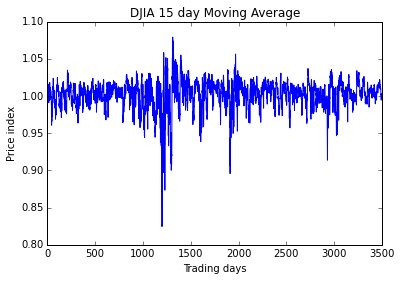

In [264]:
from matplotlib import pyplot
pyplot.plot(classification_df.DJIA_Close_15)
pyplot.xlabel("Trading days")
pyplot.ylabel("Price index")
pyplot.title("DJIA 15 day Moving Average")
pyplot.show()

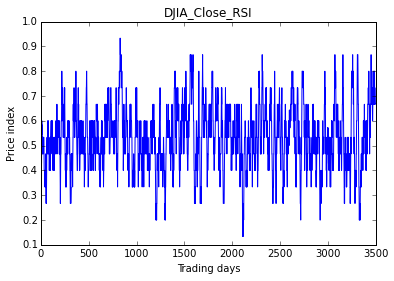

In [265]:
from matplotlib import pyplot
pyplot.plot(classification_df.DJIA_Close_RSI)
pyplot.xlabel("Trading days")
pyplot.ylabel("Price index")
pyplot.title("DJIA_Close_RSI")
pyplot.show()

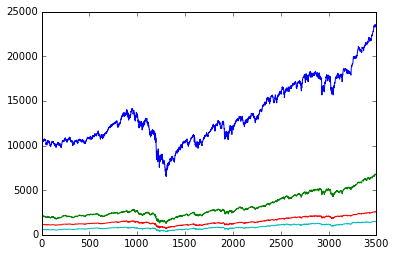

In [266]:
pyplot.plot(data.DJIA_Close)
pyplot.plot(data.NASDAQ_Close)
pyplot.plot(data.SP_Close)
pyplot.plot(data.R2000_Close)
pyplot.show()

In [267]:
classification_df_train, classification_df_test = classification_df[:2500], classification_df[2500:]
classification_df_train.head(20)

# Show the results of the split
print "Training set has {} samples.".format(len(classification_df_train))
print "Testing set has {} samples.".format(len(classification_df_test))

Training set has 2500 samples.
Testing set has 994 samples.


In [268]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score
from time import time

def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    ''' 
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train, y_train)
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    from sklearn.metrics import accuracy_score
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
                   
    # Return the results
    return results

In [298]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# TODO: Initialize the three models
clf_A = GradientBoostingClassifier(random_state=10)
clf_B = RandomForestClassifier(random_state=10)
clf_C = LinearSVC(random_state=150)
clf_D = LogisticRegression(random_state=150)
clf_E = SGDClassifier(random_state=10)

def GetData(features):
    X_train = classification_df_train[features]
    X_test = classification_df_test[features]
    y_train = classification_df_train.label
    y_test = classification_df_test.label
    return X_train, y_train, X_test, y_test

def DoExperiment(features, clf):
    X_train, y_train, X_test, y_test = GetData(features)
    return train_predict(clf, X_train, y_train, X_test, y_test)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_E,]:
    clf_name = clf.__class__.__name__
    print clf_name
    results[clf_name] = DoExperiment(features[1:], clf)

#vs.evaluate(results, accuracy)
pd.DataFrame(results)

GradientBoostingClassifier
RandomForestClassifier
SGDClassifier


,GradientBoostingClassifier,RandomForestClassifier,SGDClassifier
acc_test,0.608652,0.472837,0.454728
acc_train,0.620000,0.960000,0.426667
pred_time,0.006390,0.017847,0.001223
train_time,0.998153,0.086198,0.010043


In [329]:
# METHODOLOGY STEP THIRTEEN ~ OBSERVE INDIVIDUAL FEATURES  TEST RESULTS
import collections
model = GradientBoostingClassifier(random_state=2, n_estimators=10)
selected_features = sorted_features[-5:]
print DoExperiment(selected_features,  model)
collections.Counter(model.predict(classification_df_test[selected_features]))


{'train_time': 0.07674002647399902, 'acc_train': 0.55000000000000004, 'pred_time': 0.002073049545288086, 'acc_test': 0.61670020120724345}


Counter({'Buy': 9, 'Short': 12, 'do nothing': 973})

In [300]:
import collections
model = GradientBoostingClassifier(random_state=10, n_estimators=20)
DoExperiment(features[1:],  model)
preds = model.predict(classification_df_test[features[1:]])
collections.Counter(preds)

Counter({'Buy': 14, 'Short': 5, 'do nothing': 975})

In [301]:
classification_df_test.label.value_counts() / float(len(classification_df_test))

do nothing    0.61670
Buy           0.21328
Short         0.17002
Name: label, dtype: float64

In [302]:
collections.Counter(zip(classification_df_test.label, preds))

Counter({('Buy', 'Buy'): 5,
         ('Buy', 'Short'): 2,
         ('Buy', 'do nothing'): 205,
         ('Short', 'Buy'): 4,
         ('Short', 'Short'): 1,
         ('Short', 'do nothing'): 164,
         ('do nothing', 'Buy'): 5,
         ('do nothing', 'Short'): 2,
         ('do nothing', 'do nothing'): 606})

In [322]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer

X_train, y_train, X_test, y_test = GetData(features[1:])

# TODO: Train the supervised model on the training set 
model = GradientBoostingClassifier().fit(X_train, y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_
importance_list = zip(importances, features[1:])
importance_list = sorted(importance_list, key=lambda x: x[0])
for name, value in importance_list:
    print name, value
# Plot
#vs.feature_plot(importances, X_train, y_train)
_,  sorted_features = zip(*importance_list)
sorted_features = list(sorted_features)

0.00187255955727 growth
0.00713144818716 economics
0.00762809890941 leverage
0.00930625684522 portfolio
0.010086522024 unemployment
0.0124265996993 credit
0.0126964266716 hedge
0.0135892680064 housing
0.0139148484908 return
0.0139929712574 dow_jones
0.0149350909224 revenue
0.0151772355239 derivatives
0.0152542942843 markets
0.0175260498478 restaurant
0.0177964360873 inflation
0.0186284641058 money
0.0200899802282 stocks
0.0222132100768 debt
0.0243127880832 investment
0.0745585041508 DJIA_Close_breakout
0.0929410844406 DJIA_Close_RSI
0.5639218626 DJIA_Close_15


In [109]:


# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

best_clf = model
# Train on the "best" model found from grid search with all features
start = time()
clf = (clone(best_clf)).fit(X_train_reduced, y_train)
end = time()
train_time_all = end - start

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Train on the "best" model found from grid search after feature reduction
start = time()
clf = (clone(best_clf)).fit(X_train_reduced, y_train)
end = time()
train_time_reduced = end - start

start = time()
clf = (clone(best_clf)).fit(X_train_reduced, y_train)
end = time()
test_time_reduced = end - start

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "Training Time Full Model: {:.4f}".format(train_time_all)
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))
print "Training Time Reduced Model: {:.4f}".format(train_time_reduced)

Final Model trained on full data
------


NameError: name 'best_predictions' is not defined

In [200]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import lstm, time #helper libraries

In [201]:
#Step 1 Load Data
X_train, y_train, X_test, y_test = lstm.load_data('DJIA_fixed.csv', 50, True)

In [202]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
   input_dim=1,
   output_dim=50,
   return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
   return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
   output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print 'compilation time : ', time.time() - start

compilation time :  0.0529608726501


In [203]:
#Step 3 Train the model
model.fit(
   X_train,
   y_train,
    batch_size=512,
   nb_epoch=1,
    validation_split=0.05)

Train on 2945 samples, validate on 156 samples
Epoch 1/1
2945/2945 [==============================] - 9s 3ms/step - loss: 0.0021 - val_loss: 0.0010


               DJIA test data price movements


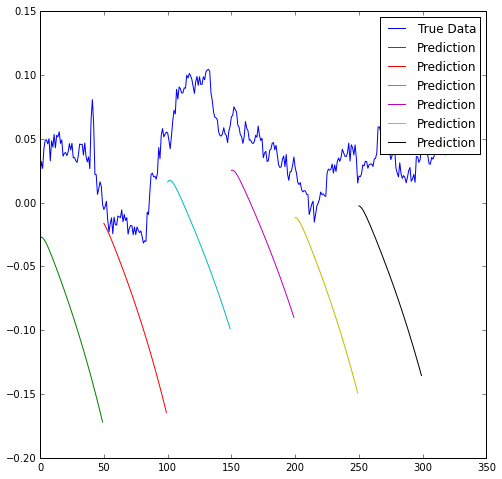

In [206]:
#Step 4 - Plot the predictions!
predictions = lstm.predict_sequences_multiple(model, X_test, 50, 50)
plot_results_multiple(predictions, y_test, 50)

In [204]:
from matplotlib import pyplot as plt
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white', figsize=(8, 8))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    print '               DJIA test data price movements'
    #Pad the list of predictions to shift it in the graph to it's correct start                                                                                  
    for i, data in enumerate(predicted_data):
        padding = [None for p in xrange(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [205]:
import pandas
dj_df = pandas.read_csv('DJIA.csv')
with open('DJIA_fixed.csv', 'w') as f:
    for i in range(len(dj_df)):
        item = dj_df.iloc[i].DJIA_Close
        f.write('{0}\n'.format(item))
        